# Inicio
[Enunciado.](https://docs.google.com/document/d/1Ws7kfBmQmZ3BuUA7rGCnvhRGdl6MZYpC2c2GEvx7a2Y/)\
[Informe de referencia.](https://github.com/alepenaa94/TP-Datos/blob/master/Informe-Tp1-Datos.pdf)\
[Informe nuestro.](https://docs.google.com/document/d/1bwhl1Hc5KruiIkSAe8ithz-S1LPuT_eVXhJdGVd3r4Y/edit)\
[Repositorio.](https://github.com/NicoDeGiacomo/ODD-TP1)


In [1]:
!pip install -U -q PyDrive
!pip install geopy
!pip install plotly
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
# Estilos globales para mantener un formato en todos los gráficos
global_colors=sns.color_palette("dark", as_cmap=True)
global_alpha = 0.8
global_size = (15,10)
sns.set(rc={'figure.figsize':global_size})
sns.set_palette("dark")
sns.set_style('darkgrid')

In [3]:
drive.mount("/content/drive")
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# CSV 1
url = 'https://raw.githubusercontent.com/NicoDeGiacomo/ODD-TP1/main/Datos-Empresa.csv'
df = pd.read_csv(url)
df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Unnamed: 8,Bureaucratic_Code,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,USD,0.58817,5/1/2016,6/30/2016,2016 - 5,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Qualification,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,USD,0.59948,1/18/2016,1/20/2016,2016 - 1,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Qualification,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,12/8/2015,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.48,USD,0.48000,1/25/2016,1/25/2016,2016 - 1,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Qualification,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,3/31/2018,2018 - 2,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Qualification,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,2/28/2018,2018 - 2,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Qualification,Prod_Category_A_None


In [5]:
# CSV 2
url = 'https://raw.githubusercontent.com/NicoDeGiacomo/ODD-TP1/main/PAISES.csv'
paisesYHemisferios = pd.read_csv(url)
paisesYHemisferios.head()

,Territory,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code,Unnamed: 11,Hemisphere
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN,NaN,N
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN,NaN,N
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN,NaN,N
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN,NaN,N
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN,NaN,S


# Won vs Lost by Season





In [6]:
def season_by_month(month, hemisphere):
  if (month >=7) & (month < 10):
    return "Summer" if hemisphere == "N" else "Winter"
  elif (month >= 10) & (month < 13):
    return "Autumn" if hemisphere == "N" else "Spring"
  elif (month >=1) & (month < 4):
    return "Winter" if hemisphere == "N" else "Summer"
  elif (month >=4) & (month < 7):
    return "Spring" if hemisphere == "N" else "Autumn"

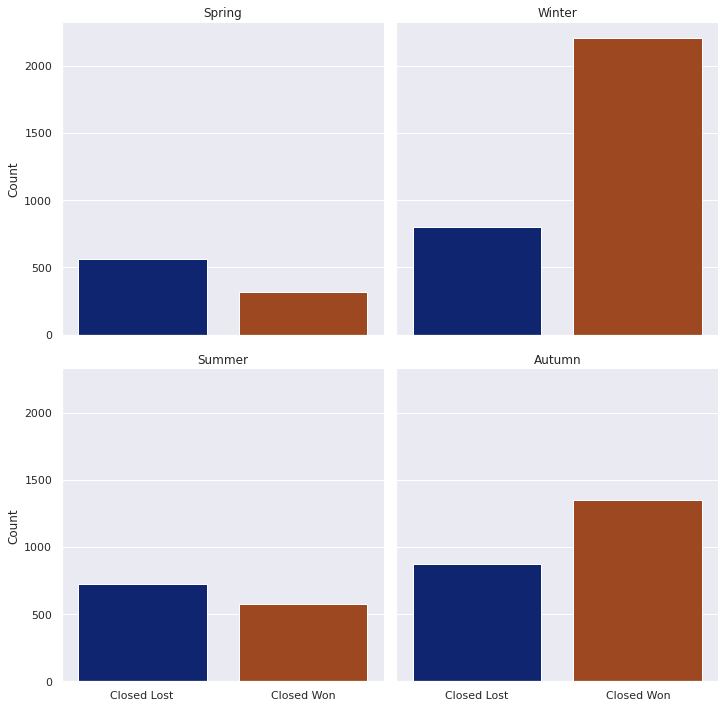

In [7]:
# Hago un Merge con el CSV de los paises
paisesYHemisferios = paisesYHemisferios.rename(columns={"Territory":"Billing_Country"})
closed_by_season = paisesYHemisferios.merge(df, how="inner", left_on="Billing_Country", right_on="Billing_Country")

# Cambio el tipo de las columnas
closed_by_season["Opportunity_Created_Date"] = pd.to_datetime(closed_by_season["Opportunity_Created_Date"])
closed_by_season["Last_Modified_Date"] = pd.to_datetime(closed_by_season["Last_Modified_Date"])

closed_by_season["Opportunity_Created_Date"] = closed_by_season["Opportunity_Created_Date"].apply(lambda x: str(x.date())[:-3])
closed_by_season["Last_Modified_Date"] = closed_by_season["Last_Modified_Date"].apply(lambda x: str(x.date())[:-3])
closed_by_season = closed_by_season[["Hemisphere","Opportunity_Created_Date", "Last_Modified_Date", "Stage", "Opportunity_ID", "Billing_Country"]].drop_duplicates()

# Filtro por Stage
closed_by_season = closed_by_season[(closed_by_season["Stage"] == "Closed Won") | (closed_by_season["Stage"] == "Closed Lost")]

# Calculo la estación dependiendo del mes y del hemisferio
closed_by_season["Opportunity_Created_Date"] = closed_by_season.agg({"Opportunity_Created_Date":[lambda x: pd.to_datetime(x, format="%Y-%m").month]})#.droplevel(1, axis=1)
closed_by_season["Last_Modified_Date"] = closed_by_season.agg({"Last_Modified_Date":[lambda x: pd.to_datetime(x, format="%Y-%m").month]})#.droplevel(1, axis=1)

closed_by_season["Open_Season"] = closed_by_season.apply(lambda row: season_by_month(row['Opportunity_Created_Date'], row['Hemisphere']), axis=1)
closed_by_season["Closed_Season"] = closed_by_season.apply(lambda row: season_by_month(row['Last_Modified_Date'], row['Hemisphere']), axis=1)

# Hago el gráfico
g = sns.catplot(x="Stage", col="Closed_Season", data=closed_by_season, kind="count", col_wrap=2)
g.set_titles("{col_name}")
g.set_axis_labels("", "Count")
plt.show()

# Opportunities by Region

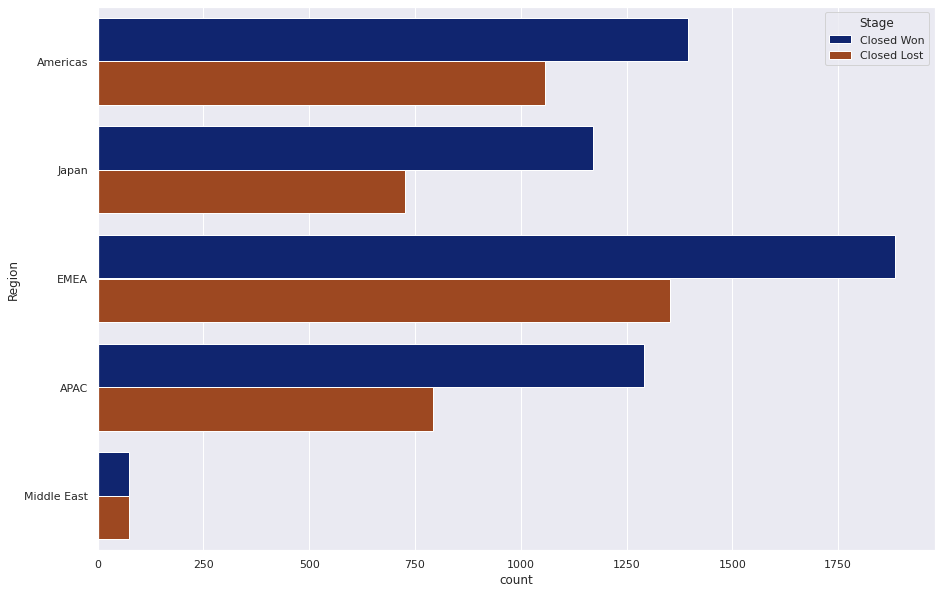

In [8]:
# Ventas por region
won_by_region = df[(df["Stage"] == "Closed Won") | (df["Stage"] == "Closed Lost")].drop_duplicates(subset="Opportunity_ID")
won_by_region = won_by_region[["Region", "Stage"]]

# Gráfico
g = sns.countplot(y="Region", hue="Stage", data=won_by_region)
plt.show()

# Conversion by seller

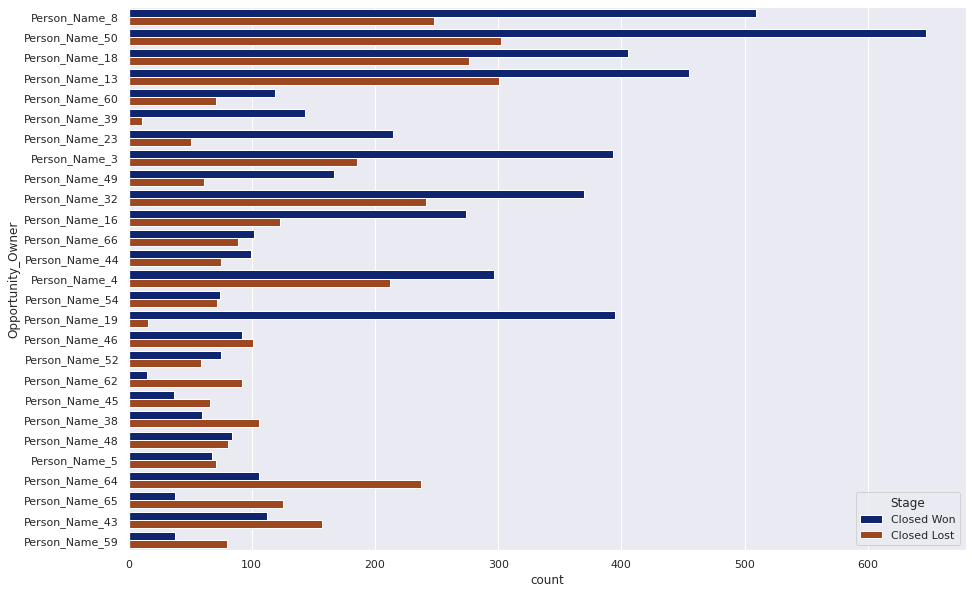

In [9]:
# Ventas por region
sell_by_seller = df[(df["Stage"] == "Closed Won") | (df["Stage"] == "Closed Lost")].drop_duplicates(subset="Opportunity_ID")
sell_by_seller = sell_by_seller[["Opportunity_Owner", "Stage"]]

# Descarto a los vendedores con menos de 100 ventas
aux = sell_by_seller
aux["count"] = 1
aux = aux.groupby(["Opportunity_Owner", "Stage"]).count().reset_index()
aux = aux.pivot_table(index="Opportunity_Owner", columns="Stage", fill_value=0).reset_index()
aux["Total"] = aux[("count", "Closed Lost")] + aux[("count", "Closed Won")]
aux = aux[["Opportunity_Owner", "Total"]].droplevel(1, axis=1)
sell_by_seller = sell_by_seller.merge(aux, on="Opportunity_Owner")
sell_by_seller = sell_by_seller[sell_by_seller["Total"] >= 100]

# Gráfico
g = sns.countplot(y="Opportunity_Owner", hue="Stage", data=sell_by_seller)
plt.show()

# Open vs Closed by Month

In [10]:
# Cambio el tipo de las columnas
df["Opportunity_Created_Date"] = pd.to_datetime(df["Opportunity_Created_Date"])
df["Last_Modified_Date"] = pd.to_datetime(df["Last_Modified_Date"])

# Filtro por fecha
last_year = df[(df["Opportunity_Created_Date"].dt.year >= 2015) & (df["Last_Modified_Date"].dt.year >= 2015)]

# Mantengo solo un producto por cada oportunidad
last_year = last_year.drop_duplicates(subset="Opportunity_ID")

# Me quedo con las columnas que necesito
last_year = last_year[["Opportunity_Created_Date", "Last_Modified_Date" ,"Stage"]]

# Me quedo solamente con el mes y el año
last_year["Opportunity_Created_Date"] = last_year["Opportunity_Created_Date"].apply(lambda x: str(x.date())[:-3])
last_year["Last_Modified_Date"] = last_year["Last_Modified_Date"].apply(lambda x: str(x.date())[:-3])

# Calculo la cantidad de oportunidades abiertas por mes
opened_by_month = last_year.groupby("Opportunity_Created_Date").count()

# Calculo la cantidad de oportunidades cerradas por mes (asumo que despues de cerrarse, el Last_Modified_Date no vuelve a cambiar)
closed_by_month = last_year[(last_year["Stage"] == "Closed Won") | (last_year["Stage"] == "Closed Lost")]
closed_by_month = last_year.groupby("Last_Modified_Date").count()

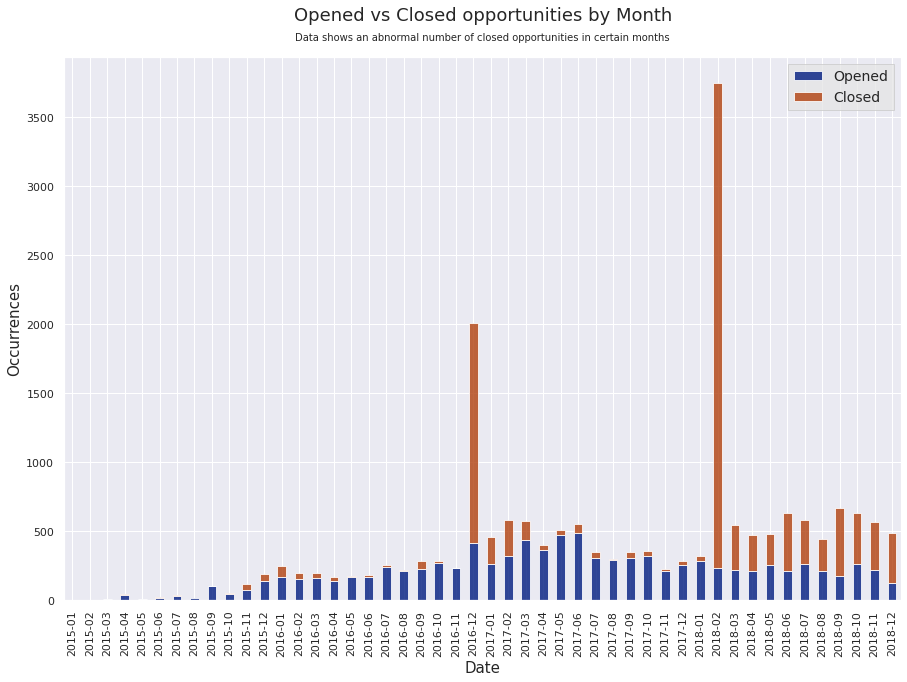

In [11]:
# Hago el gráfico
import matplotlib.pyplot as plt

by_month = opened_by_month
by_month["Stage"] = closed_by_month["Stage"]
by_month = by_month.reset_index()
by_month.columns=["Month", "Opened", "Closed"]

plot = by_month.plot(kind="bar", x="Month", stacked=True, figsize=global_size, color=global_colors, alpha=0.8)
plot.locator_params(nbins=10, axis="y")
plot.locator_params(nbins=1000, axis="x", tight=True)
plot.set_xlabel("Date", fontsize=15)
plot.set_ylabel("Occurrences", fontsize=15)
plot.legend(prop={'size': 14}, facecolor="#e6e6e6", shadow=False, fancybox=False)

plt.suptitle("Opened vs Closed opportunities by Month", y=0.95, x=0.513, fontsize=18)
plt.title("Data shows an abnormal number of closed opportunities in certain months", y=1.02, fontsize=10)
plt.show()
#Stacked area hecho en infogram:
#https://infogram.com/area-1h7j4dvzonvxx4n

# Opportunity Types

In [12]:
df_closed = df.loc[df["Stage"].str.contains("Closed"), :]
# Contamos solo una unidad por Opportunity Id
df_closed_w_duplicates = df_closed.drop_duplicates(subset="Opportunity_ID")
df_won = df_closed_w_duplicates.loc[df_closed_w_duplicates["Stage"].str.contains("Won"), :].groupby("Opportunity_Type").agg({'Stage':'count'})
df_won.columns = ["Won"]

In [13]:
df_lost = df_closed_w_duplicates.loc[df_closed_w_duplicates["Stage"].str.contains("Lost"), :].\
  groupby("Opportunity_Type").agg({'Stage':'count'})
df_lost.columns = ["Lost"]

In [14]:
win_vs_lost_op_type = df_won.merge(df_lost, on= "Opportunity_Type", how='outer')
win_vs_lost_op_type.fillna(0, inplace= True)
win_vs_lost_op_type["Won"] = win_vs_lost_op_type["Won"].astype(np.int64)
win_vs_lost_op_type["Lost"] = win_vs_lost_op_type["Lost"].astype(np.int64)
win_vs_lost_op_type["Total"] = win_vs_lost_op_type["Lost"] \
 +win_vs_lost_op_type["Won"]
win_vs_lost_op_type.nlargest(10, "Total")

,Won,Lost,Total
Opportunity_Type,,,
Opportunity_Type_1,3043,2112,5155
Opportunity_Type_7,1131,857,1988
Opportunity_Type_19,863,419,1282
Opportunity_Type_8,407,327,734
Opportunity_Type_3,72,111,183
Opportunity_Type_12,125,13,138
Opportunity_Type_20,79,56,135
Opportunity_Type_2,14,40,54
Opportunity_Type_4,28,20,48


In [15]:
# Me quedo con las oportunidades que superen el 1% del total
win_vs_lost_op_type_A = win_vs_lost_op_type.loc[win_vs_lost_op_type["Total"] > (win_vs_lost_op_type["Total"].sum() * (0.01)), :] 
win_vs_lost_op_type_A

,Won,Lost,Total
Opportunity_Type,,,
Opportunity_Type_1,3043,2112,5155
Opportunity_Type_12,125,13,138
Opportunity_Type_19,863,419,1282
Opportunity_Type_20,79,56,135
Opportunity_Type_3,72,111,183
Opportunity_Type_7,1131,857,1988
Opportunity_Type_8,407,327,734


Text(0.5, 1.0, 'Opportunities Types')

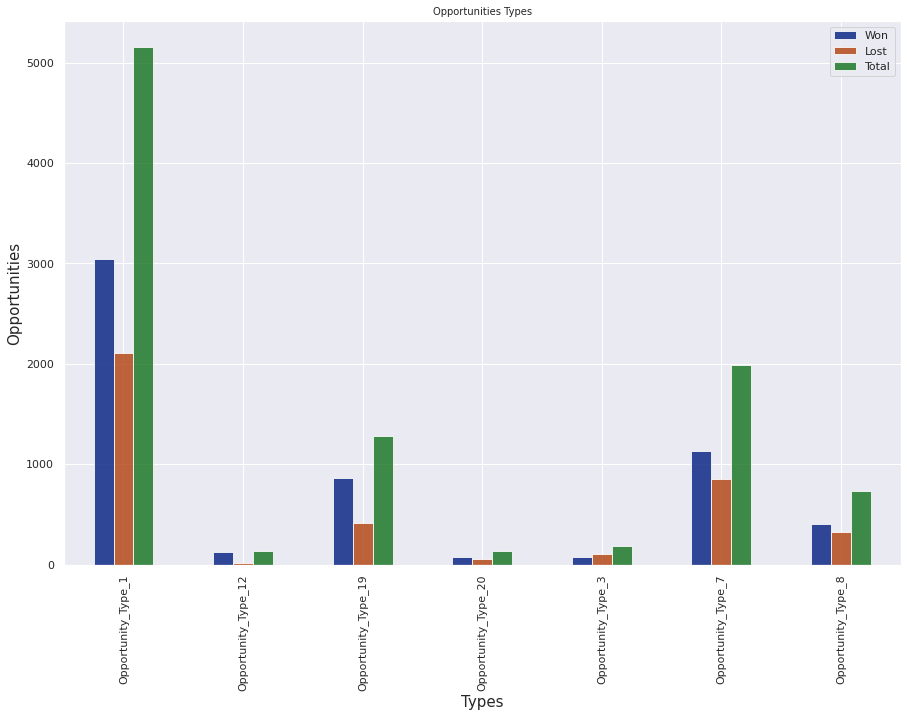

In [16]:
# Hago el gráfico
plot_op_type = win_vs_lost_op_type_A.plot(kind="bar" , stacked=False, figsize=global_size, color=global_colors, alpha=0.8)
plot_op_type.locator_params(nbins=10, axis="y")
plot_op_type.locator_params(nbins=600, axis="x", tight=True)
plot_op_type.set_xlabel("Types", fontsize=15)
plot_op_type.set_ylabel("Opportunities", fontsize=15)
plot_op_type.set_title("Opportunities Types", fontsize=10)


In [17]:
win_vs_lost_op_type_A["mean"] = win_vs_lost_op_type_A["Won"] / win_vs_lost_op_type_A["Total"]
win_vs_lost_op_type_A.reset_index(inplace=True)
win_vs_lost_op_type_A_mean = win_vs_lost_op_type_A.loc[:, ["Opportunity_Type", "mean"]]
win_vs_lost_op_type_A_mean.nlargest(10, "mean")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Opportunity_Type,mean
1,Opportunity_Type_12,0.905797
2,Opportunity_Type_19,0.673167
0,Opportunity_Type_1,0.590301
3,Opportunity_Type_20,0.585185
5,Opportunity_Type_7,0.568913
6,Opportunity_Type_8,0.554496
4,Opportunity_Type_3,0.393443


# Country by Won Percentage

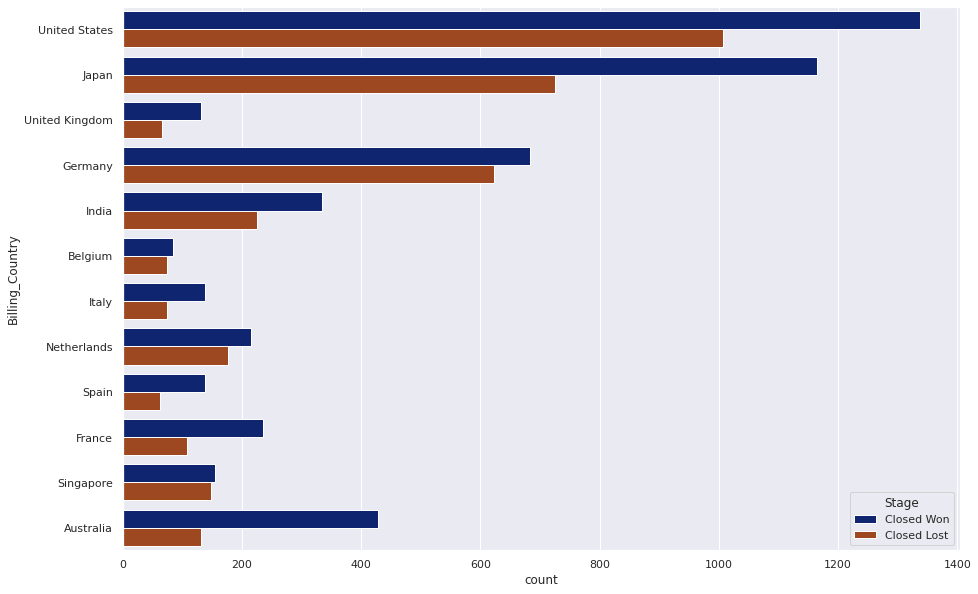

In [18]:
# Ventas por region
won_by_country = df[(df["Stage"] == "Closed Won") | (df["Stage"] == "Closed Lost")].drop_duplicates(subset="Opportunity_ID")
won_by_country = won_by_country[["Billing_Country", "Stage"]]
won_by_country

#Busco los 20 paises con mas oportunidades
aux = won_by_country
aux["count"] = 1
aux = aux.groupby(["Billing_Country", "Stage"]).count().nlargest(20, "count").reset_index()
aux = aux.pivot_table(index="Billing_Country", columns="Stage", fill_value=0).reset_index()
aux["Total"] = aux[("count", "Closed Lost")] + aux[("count", "Closed Won")]

# Gráfico 1
aux = aux[["Billing_Country", "Total"]].droplevel(1, axis=1)
won_by_country = won_by_country.merge(aux, on="Billing_Country")
g = sns.countplot(y="Billing_Country", hue="Stage", data=won_by_country)

plt.show()

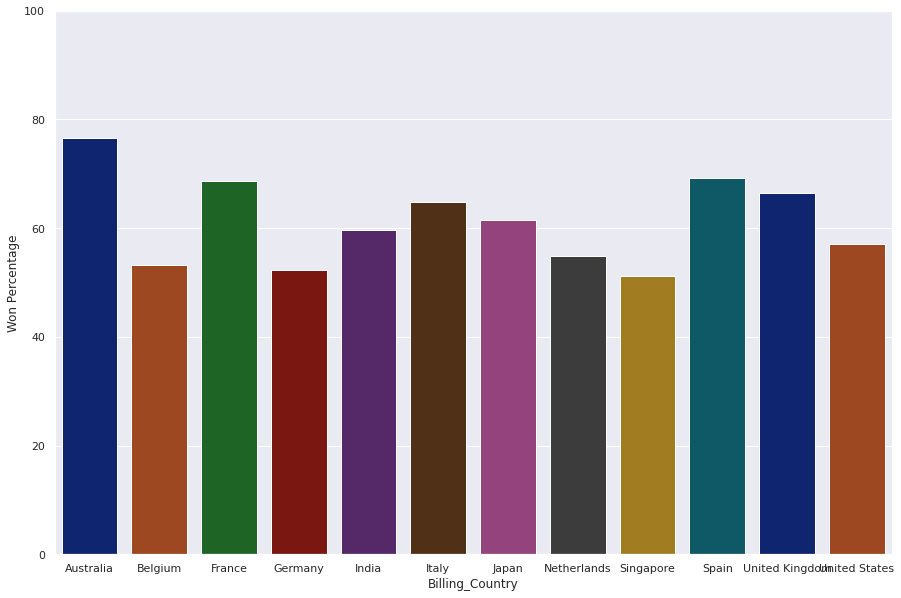

In [19]:
# Gráfico 2
aux3 = won_by_country.groupby(["Billing_Country", "Stage"]).count().reset_index().pivot_table(index="Billing_Country", columns="Stage", fill_value=0).reset_index()
aux3["Sum"] = aux3[("count", "Closed Lost")] + aux3[("count", "Closed Won")]
aux3["Won Percentage"] = (aux3[("count", "Closed Won")] / aux3["Sum"])*100
g2 = sns.barplot(data=aux3, y="Won Percentage", x="Billing_Country", palette="dark")
g2.set(ylim=(0, 100))
plt.show()

In [20]:
import plotly.express as px
import plotly.graph_objects as go
from geopy.geocoders import Nominatim

fig = go.Figure()
fig.update_layout(geo=dict(bgcolor= 'grey', landcolor = "black"))

tmp = aux3.nlargest(5,"Sum")[["Billing_Country", "Sum", "Won Percentage"]]
tmp.columns=["Country","Sum","P"]
i=0
for index, row in tmp.iterrows():
  geolocator = Nominatim(user_agent="random")
  location = geolocator.geocode(row["Country"])

  fig.add_trace(go.Scattergeo(
      lon = (location.longitude,),
      lat = (location.latitude,),
      text = row["Sum"],
      marker = dict(
          size = row["Sum"]/20,
          color = 'rgb(102,17,0)',
          line_width = 0
          )))

  fig['data'][i].update(mode='markers+text', textposition='bottom center', text=row["Country"], textfont=dict(color="white", size=20))
  i+=1

for index, row in tmp.iterrows():
  geolocator = Nominatim(user_agent="random")
  location = geolocator.geocode(row["Country"])

  fig.add_trace(go.Scattergeo(
        lon = (location.longitude,),
        lat = (location.latitude,),
        text = row["P"],
        marker = dict(
            size = (row["Sum"]/20)*(row["P"]/100),
            color = 'rgb(136,34,50)',
            line_width = 0
            )))
  
fig.update_layout(
    showlegend=False,
    width=1350,
    height=1350,)

fig.show()

# Aprovación vs Éxito

In [21]:
need_app = df[((df["Pricing, Delivery_Terms_Quote_Appr"] != 0) & (df["Stage"].str.contains("Closed")))]
need_app = need_app.drop_duplicates(subset="Opportunity_ID")

no_need_app = df[((df["Pricing, Delivery_Terms_Quote_Appr"] == 0) & (df["Stage"].str.contains("Closed")))]
no_need_app = no_need_app.drop_duplicates(subset="Opportunity_ID")

need_stats = need_app.groupby("Stage").agg({"ID": "count"}).reset_index()
no_need_stats = no_need_app.groupby("Stage").agg({"ID": "count"}).reset_index()

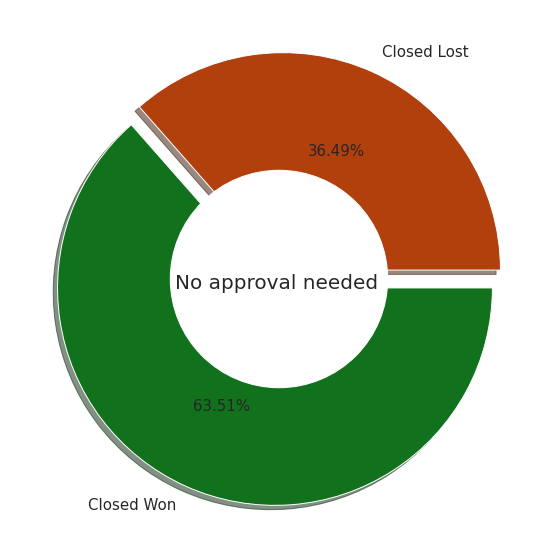

In [22]:
# Make a pie
plt.pie(no_need_stats['ID'], labels=no_need_stats["Stage"], autopct='%1.2f%%', colors=[global_colors[1], global_colors[2]], explode=[0.045,0.045], shadow=True, textprops={"fontsize":15})
plt.suptitle("No approval needed", y=0.51, x=0.51, fontsize=20)

# Make a donut
my_circle=plt.Circle((0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

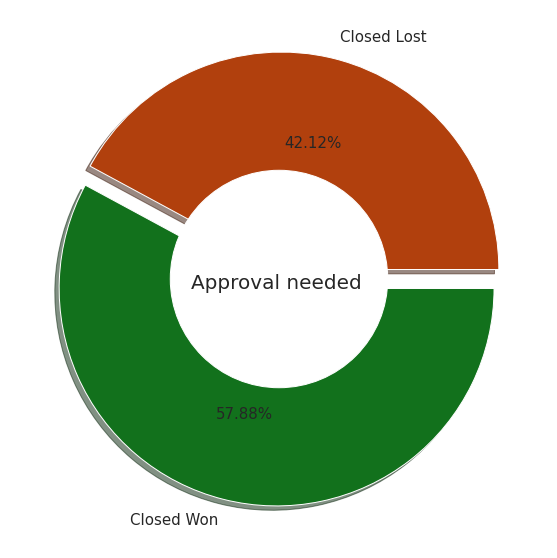

In [23]:
# Make a pie
plt.pie(need_stats['ID'], labels=need_stats["Stage"], autopct='%1.2f%%', colors=[global_colors[1], global_colors[2]], explode=[0.045,0.045], shadow=True, textprops={"fontsize":15})
plt.suptitle("Approval needed", y=0.51, x=0.51, fontsize=20)

# Make a donut
my_circle=plt.Circle((0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [24]:
#Semi-circle hecho en Infogram
#https://infogram.com/area-1h7j4dvzonvxx4n
print("Approval needed:",len(need_app))
print("No approval needed:",len(no_need_app))
print("Total:",len(need_app)+len(no_need_app))
#print(sns.color_palette("dark").as_hex())
#(sns.color_palette("dark").as_hex())

Approval needed: 7496
No approval needed: 2324
Total: 9820


# Compradores y Éxito

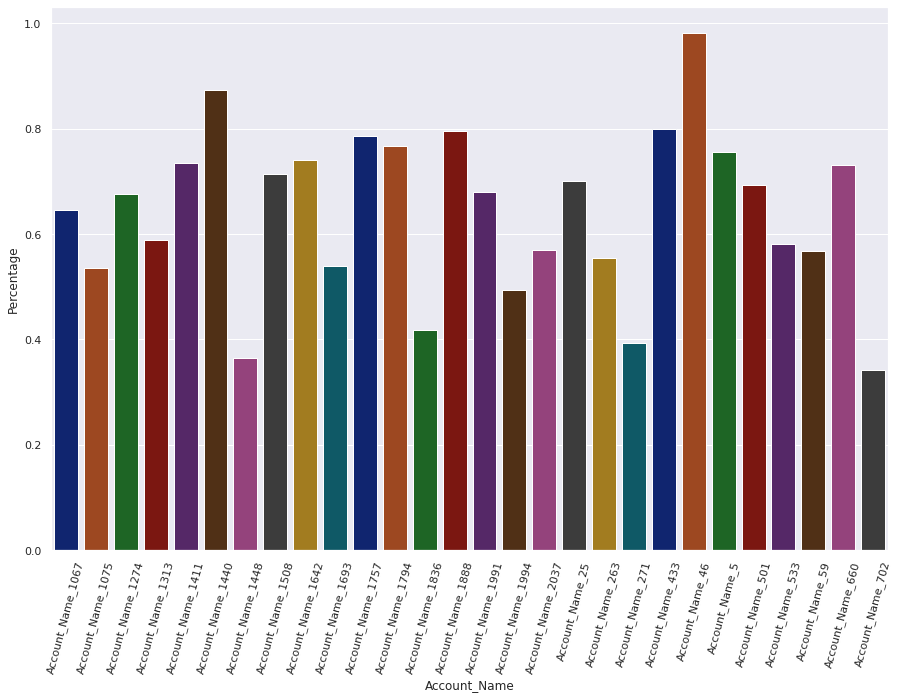

In [25]:
# Exito por Account_Name
by_client = df[df["Stage"].str.contains("Closed")]
by_client = by_client.drop_duplicates(subset="Opportunity_ID")

# Estadisticas sobre los clientes
by_client = by_client.groupby(["Account_Name", "Stage"]).count().reset_index()#[["ID", "Stage"]]
by_client = by_client[["Account_Name", "Stage", "ID"]]
by_client = by_client.pivot_table(index="Account_Name", columns="Stage", values="ID", fill_value=0).reset_index()
by_client["Total"] = by_client["Closed Lost"] + by_client["Closed Won"]
by_client["Percentage"] = by_client["Closed Won"] / by_client["Total"]

# Elimino los vendedores con menos de 50 compras
by_client = by_client[by_client["Total"] >= 50]

g = sns.barplot(x="Account_Name", y="Percentage", data=by_client, palette=global_colors)
plt.xticks(rotation=75)

plt.show()

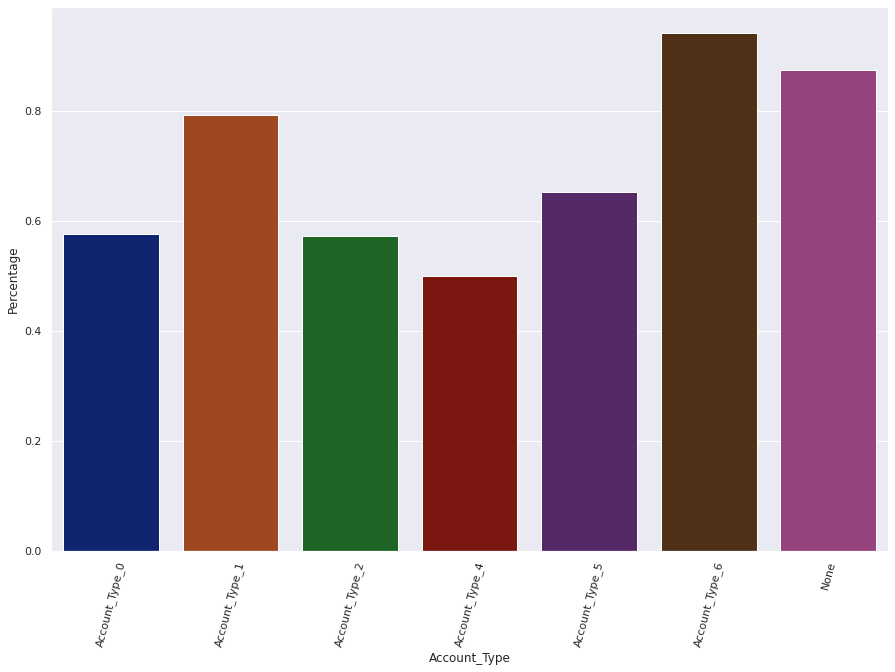

In [26]:
# Exito por Account_Type
by_client = df[df["Stage"].str.contains("Closed")]
by_client = by_client.drop_duplicates(subset="Opportunity_ID")

# Estadisticas sobre los clientes
by_client = by_client.groupby(["Account_Type", "Stage"]).count().reset_index()#[["ID", "Stage"]]
by_client = by_client[["Account_Type", "Stage", "ID"]]
by_client = by_client.pivot_table(index="Account_Type", columns="Stage", values="ID", fill_value=0).reset_index()
by_client["Total"] = by_client["Closed Lost"] + by_client["Closed Won"]
by_client["Percentage"] = by_client["Closed Won"] / by_client["Total"]

g = sns.barplot(x="Account_Type", y="Percentage", data=by_client, palette=global_colors)
plt.xticks(rotation=75)

plt.show()